In [1]:
import os
import sys
import yaml
import math
import pickle
import itertools

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from collections import defaultdict

from bson.objectid import ObjectId
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl

import src.utils.numpy_nest_utils as np_nest
from src.utils.sacred_retrieval import SacredExperimentAccess, get_dicts_key_subset, get_unique_dicts, flatten_dict
from experiments.dispatch.dispatch_utils import nested_dict_to_option_strings

# plotting
# %config InlineBackend.figure_formats = ['svg']
# %matplotlib inline
mpl.rcParams['figure.dpi'] = 300

# Tuning our best bet of DP-PVI for a single case
We're going to see how well we can do on DP-PVI for a single number of clients, namely $M=20$, for the subsample and redistribute version of the algorithm, with the downside of not benifiting from subsamling due to the complications of using the indicies. We will look at a number of cases for the algorithm, and also should look at the individual $t_i$ of the clients for a good baseline.

In the previous notebook, we looked at damping in PVI. This is clearly needed for it to run well. We're going to add it into the DP-PVI algorithm, occuring before clipping, to make sure it is included. The clipping may be more exptreme than the damping anyway, but it also may not be.

Regurgitating the damping plots from before (only for $M=20$):

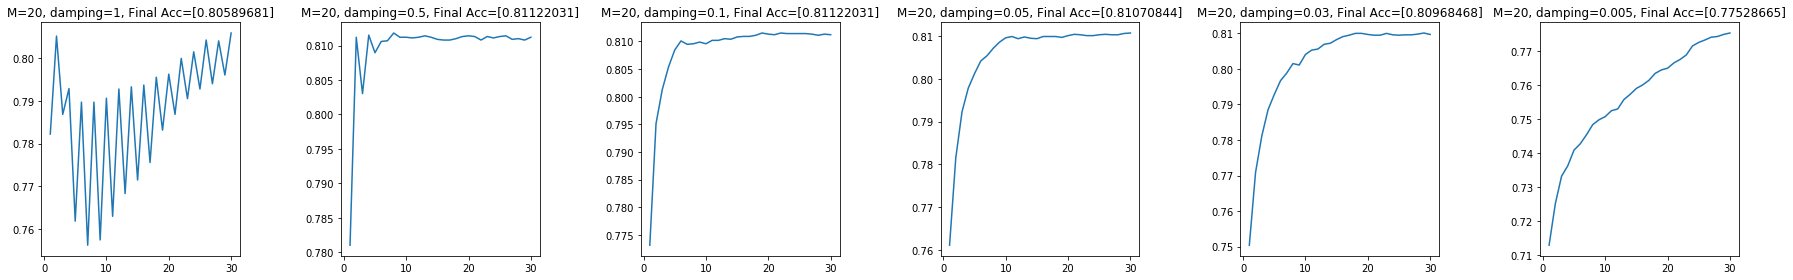

In [2]:
with open('../experiment_configs/PVI_client_damping_investigation.yaml', 'r') as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)
    
experiment_config = flatten_dict(experiment_config)

remove_list = []
for k, v in experiment_config.items():
    if isinstance(v, list):
        if len(v) == 1:
            remove_list.append(k)
        else:
            continue
    else:
        remove_list.append(k)
        
for k in remove_list: experiment_config.pop(k)

experiment_config['dataset_dist.M'] = [20]

all_options = nested_dict_to_option_strings(experiment_config)
product = itertools.product(*all_options)
dp_configs = [dict(item) for item in product]

adult_configs = dp_configs
# abalone_configs = [d for d in dp_configs if d['dataset.name'] == 'abalone']

Ms = experiment_config['dataset_dist.M']
damping_factors = experiment_config['PVI_settings.damping_factor']

results_access = SacredExperimentAccess(database_name='PVI_client_damping_investigation')

adult_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=True, config=config) for config in adult_configs]
# abalone_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=True, config=config) for config in abalone_configs]

adult_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_experiments]
# abalone_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in abalone_experiments]

plt.figure(figsize=(25,4))
rows = len(Ms)
cols = len(damping_factors)

for config, experiment, metrics in zip(adult_configs, adult_experiments, adult_metrics):
    M = config['dataset_dist.M']
    damping_factor = config['PVI_settings.damping_factor']
    
    M_index = Ms.index(M)
    damping_index = damping_factors.index(damping_factor)
    
    plt.subplot(rows, cols, M_index * cols + damping_index + 1)
    
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T
    
    plt.plot(steps, values)
    plt.title(f'M={M}, damping={damping_factor}, Final Acc={values[-1]}')
    
plt.tight_layout()

Looks like 0.1 will do the trick. Interestingly, does not seem to slow down convergance much. Less time wasted moving erraically perhaps. 

Let's grid over DP-PVI for a range of $C$ and $L$, picking $\sigma_{eff}$ to be 1 for now (might want to revisit later). We also want to look at the local $t_i$ and how closely we can match them with this agorithm. We shall need to save these for this experiment. We're going to look at the KL between different seeds, for a look at the variability between the parameters between runs (maybe looking for the max divergence pair?) and also the divergence between the individual $t_i$ in each client, and of the global parameters.

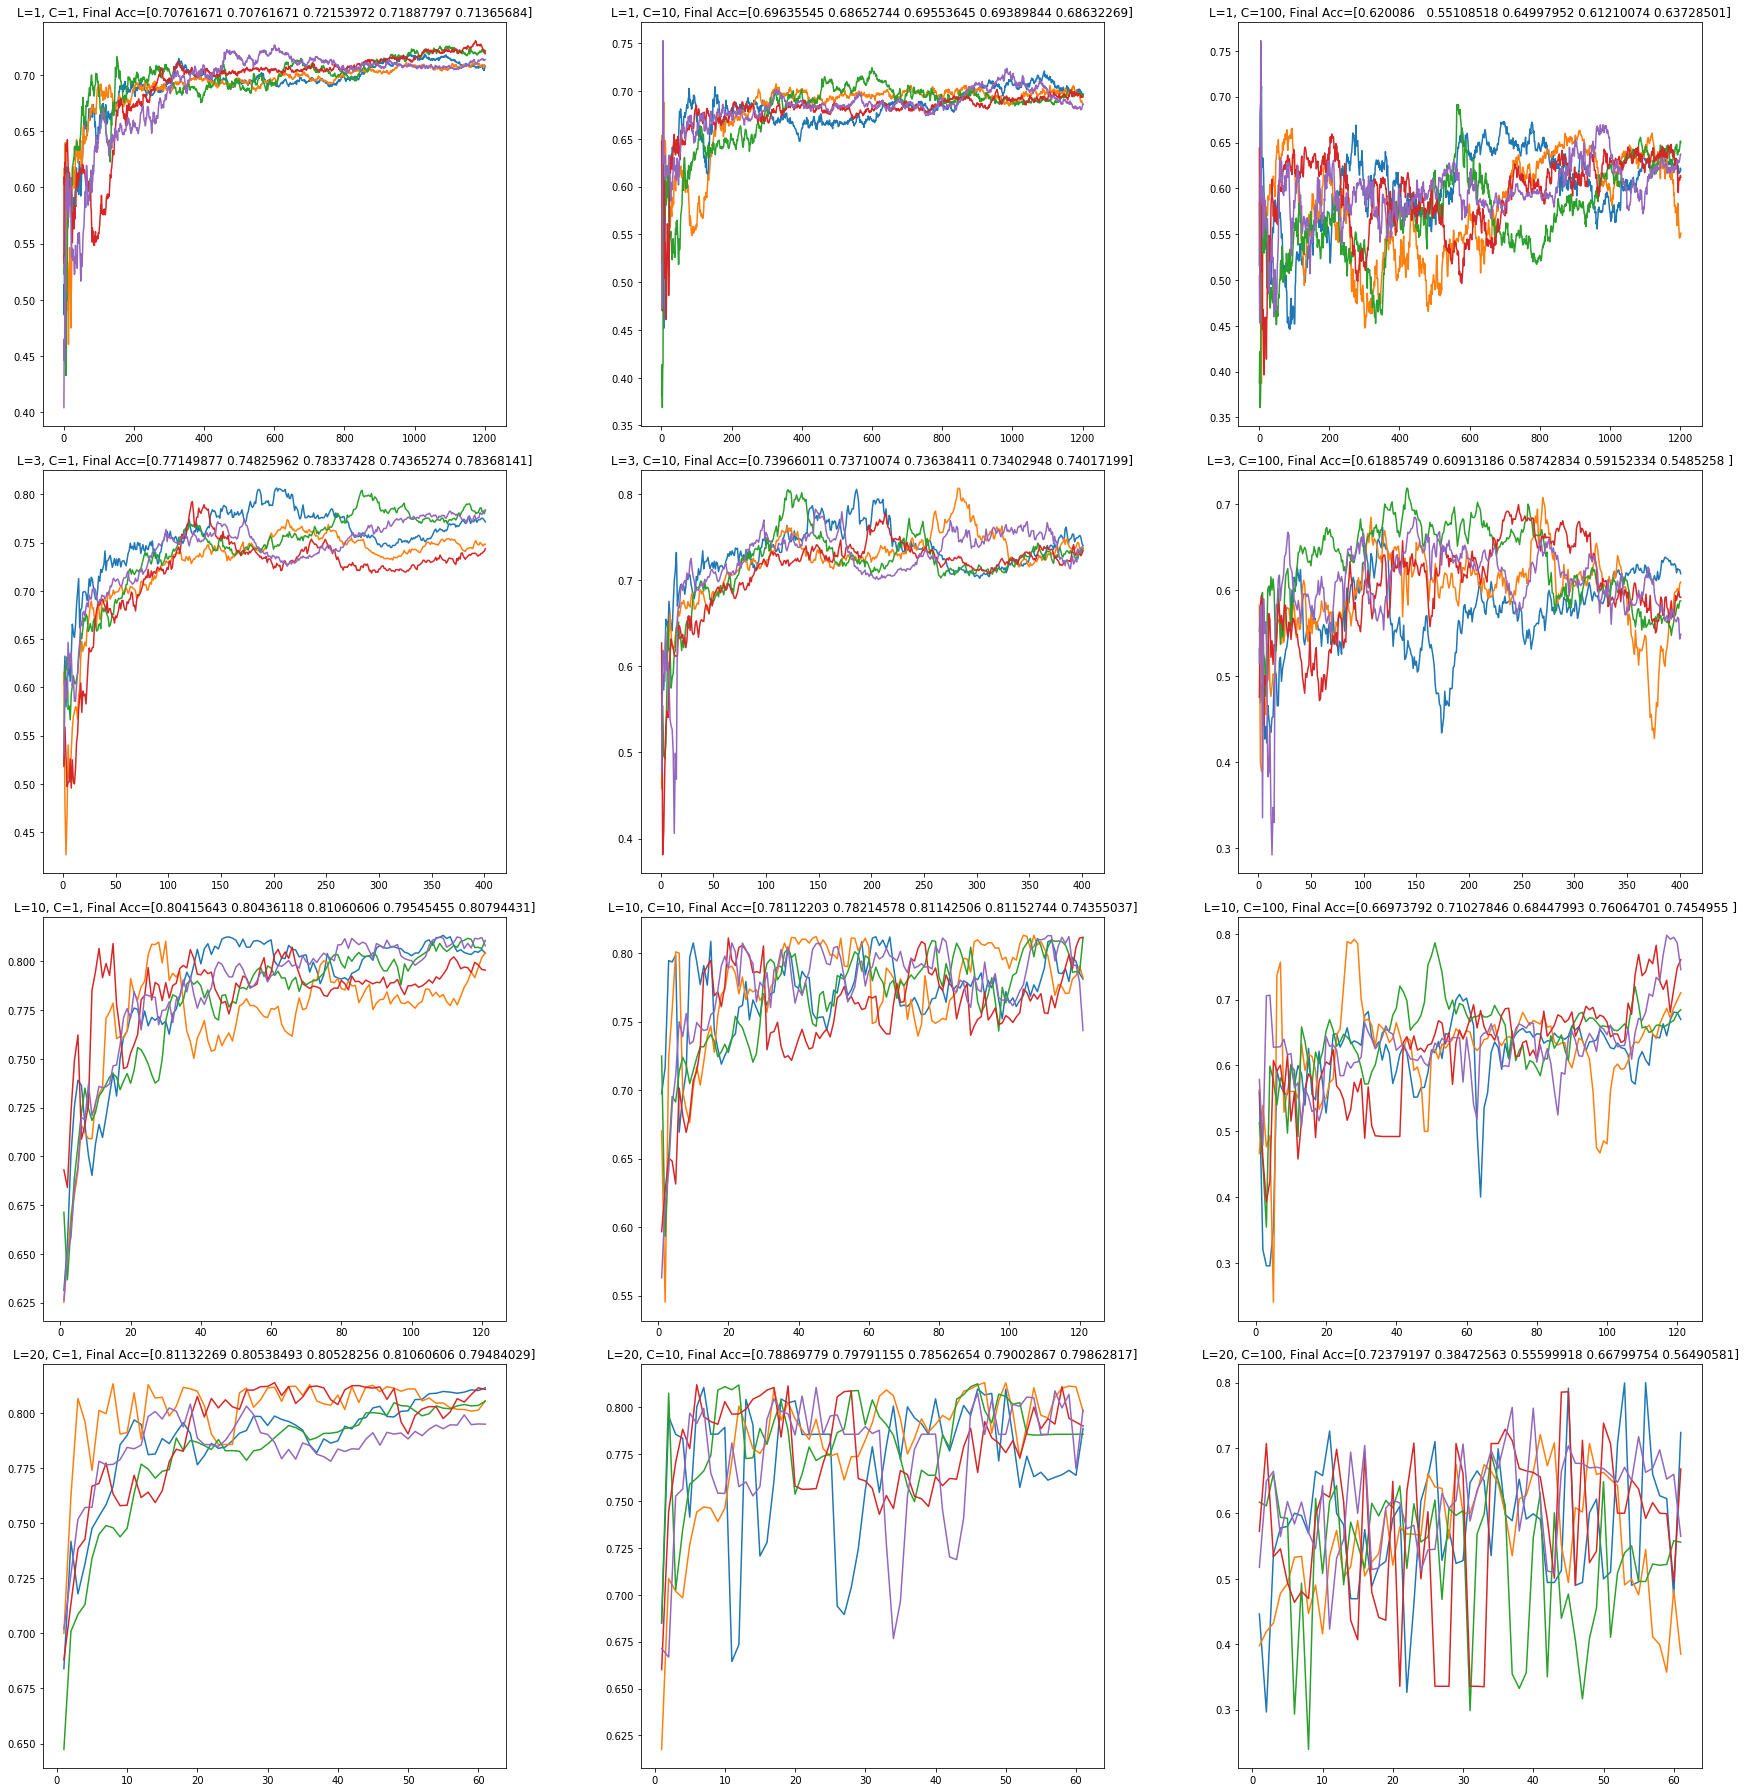

In [3]:
with open('../experiment_configs/M=20_tuning_pres_clipping_fix/client_homo_bad_q_one.yaml', 'r') as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)
    
database_name = experiment_config['database']
if isinstance(database_name, list):
    database_name = database_name[0]
    
experiment_config = flatten_dict(experiment_config)

remove_list = []
for k, v in experiment_config.items():
    if isinstance(v, list):
        if len(v) == 1:
            remove_list.append(k)
        else:
            continue
    else:
        remove_list.append(k)
        
for k in remove_list: experiment_config.pop(k)
    
experiment_config['privacy_settings.sigma_relative'] = 1.

all_options = nested_dict_to_option_strings(experiment_config)
product = itertools.product(*all_options)
dp_configs = [dict(item) for item in product]

adult_grid_configs = dp_configs

Ls = experiment_config['privacy_settings.L']
Cs = experiment_config['privacy_settings.C']

results_access = SacredExperimentAccess(database_name=database_name)

adult_grid_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=True, config=config) for config in adult_grid_configs]
# abalone_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=True, config=config) for config in abalone_configs]

adult_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_grid_experiments]
# abalone_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in abalone_experiments]

plt.figure(figsize=(25,25))
rows = len(Ls)
cols = len(Cs)

for config, experiments, metrics in zip(adult_grid_configs, adult_grid_experiments, adult_grid_metrics):
    L = config['privacy_settings.L']
    C = config['privacy_settings.C']
    
    L_index = Ls.index(L)
    C_index = Cs.index(C)
    
    plt.subplot(rows, cols, L_index * cols + C_index + 1)
        
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T
    
    plt.title(f'L={L}, C={C}, Final Acc={values[-1]}')
    
    plt.plot(steps, values)
    
plt.tight_layout()

And the PVI baseline to compare to:

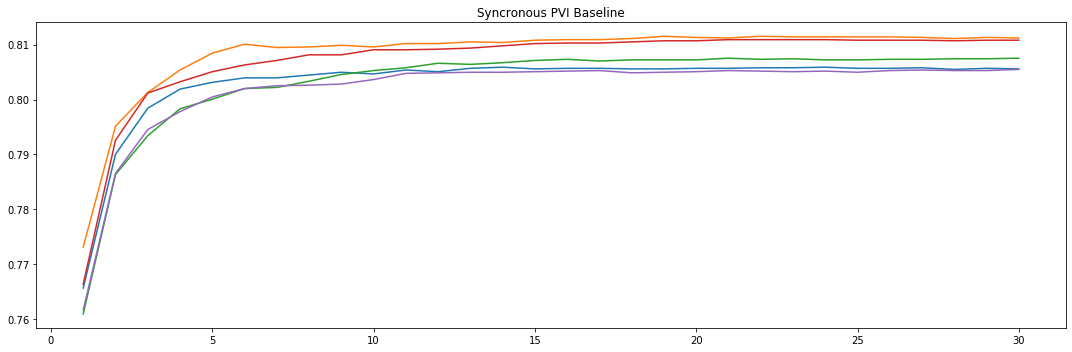

In [4]:
adult_PVI_config = {'experiment_tag': 'pure_pvi'}

results_access = SacredExperimentAccess(database_name=database_name)

adult_PVI_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=True, config=adult_PVI_config)]
# abalone_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=True, config=config) for config in abalone_configs]

adult_PVI_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_PVI_experiments]
# abalone_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in abalone_experiments]

plt.figure(figsize=(15,5))

plt.title(f'Syncronous PVI Baseline')

values = []
for metric in adult_PVI_metrics[0]:
    values.append(metric[0]['values'])
values = np.array(values).T
steps = np.atleast_2d(np.array(adult_PVI_metrics[0][0][0]['steps'])).T

plt.plot(steps, values)
    
plt.tight_layout()

Now lets take a look at the model parameters, both at a client level and at a global level. What we want to see is both good client mathces, and good global matches (to the baseline PVI ones). We dont think this will be the case however

In [5]:
adult_PVI_client_parameters = []
for experiment in adult_PVI_experiments[0]:
    file_id = experiment['artifacts'][1]['file_id']
    raw = results_access.get_artifacts_by_id([file_id])[0]
    adult_PVI_client_parameters.append(pickle.loads(raw))
    
adult_PVI_global_parameters = []
for client_parameters in adult_PVI_client_parameters:
    global_parameters = np_nest.map_structure(np.zeros_like, client_parameters[0])
    for param in client_parameters:
        global_parameters = np_nest.map_structure(np.add, global_parameters, param)
    adult_PVI_global_parameters.append(global_parameters)

In [6]:
def to_mean_var(nat_1, nat_2):
    return nat_1 / (2 * nat_2), 1 / (2 * nat_2)

def normal_kl(mean_1, var_1, mean_2, var_2):
    var_ratio = var_1 / var_2
    scaled_mean_diff = ((mean_1 - mean_2) ** 2) / var_2
    return 0.5 * (var_ratio + scaled_mean_diff - np.log(var_ratio) - 1)

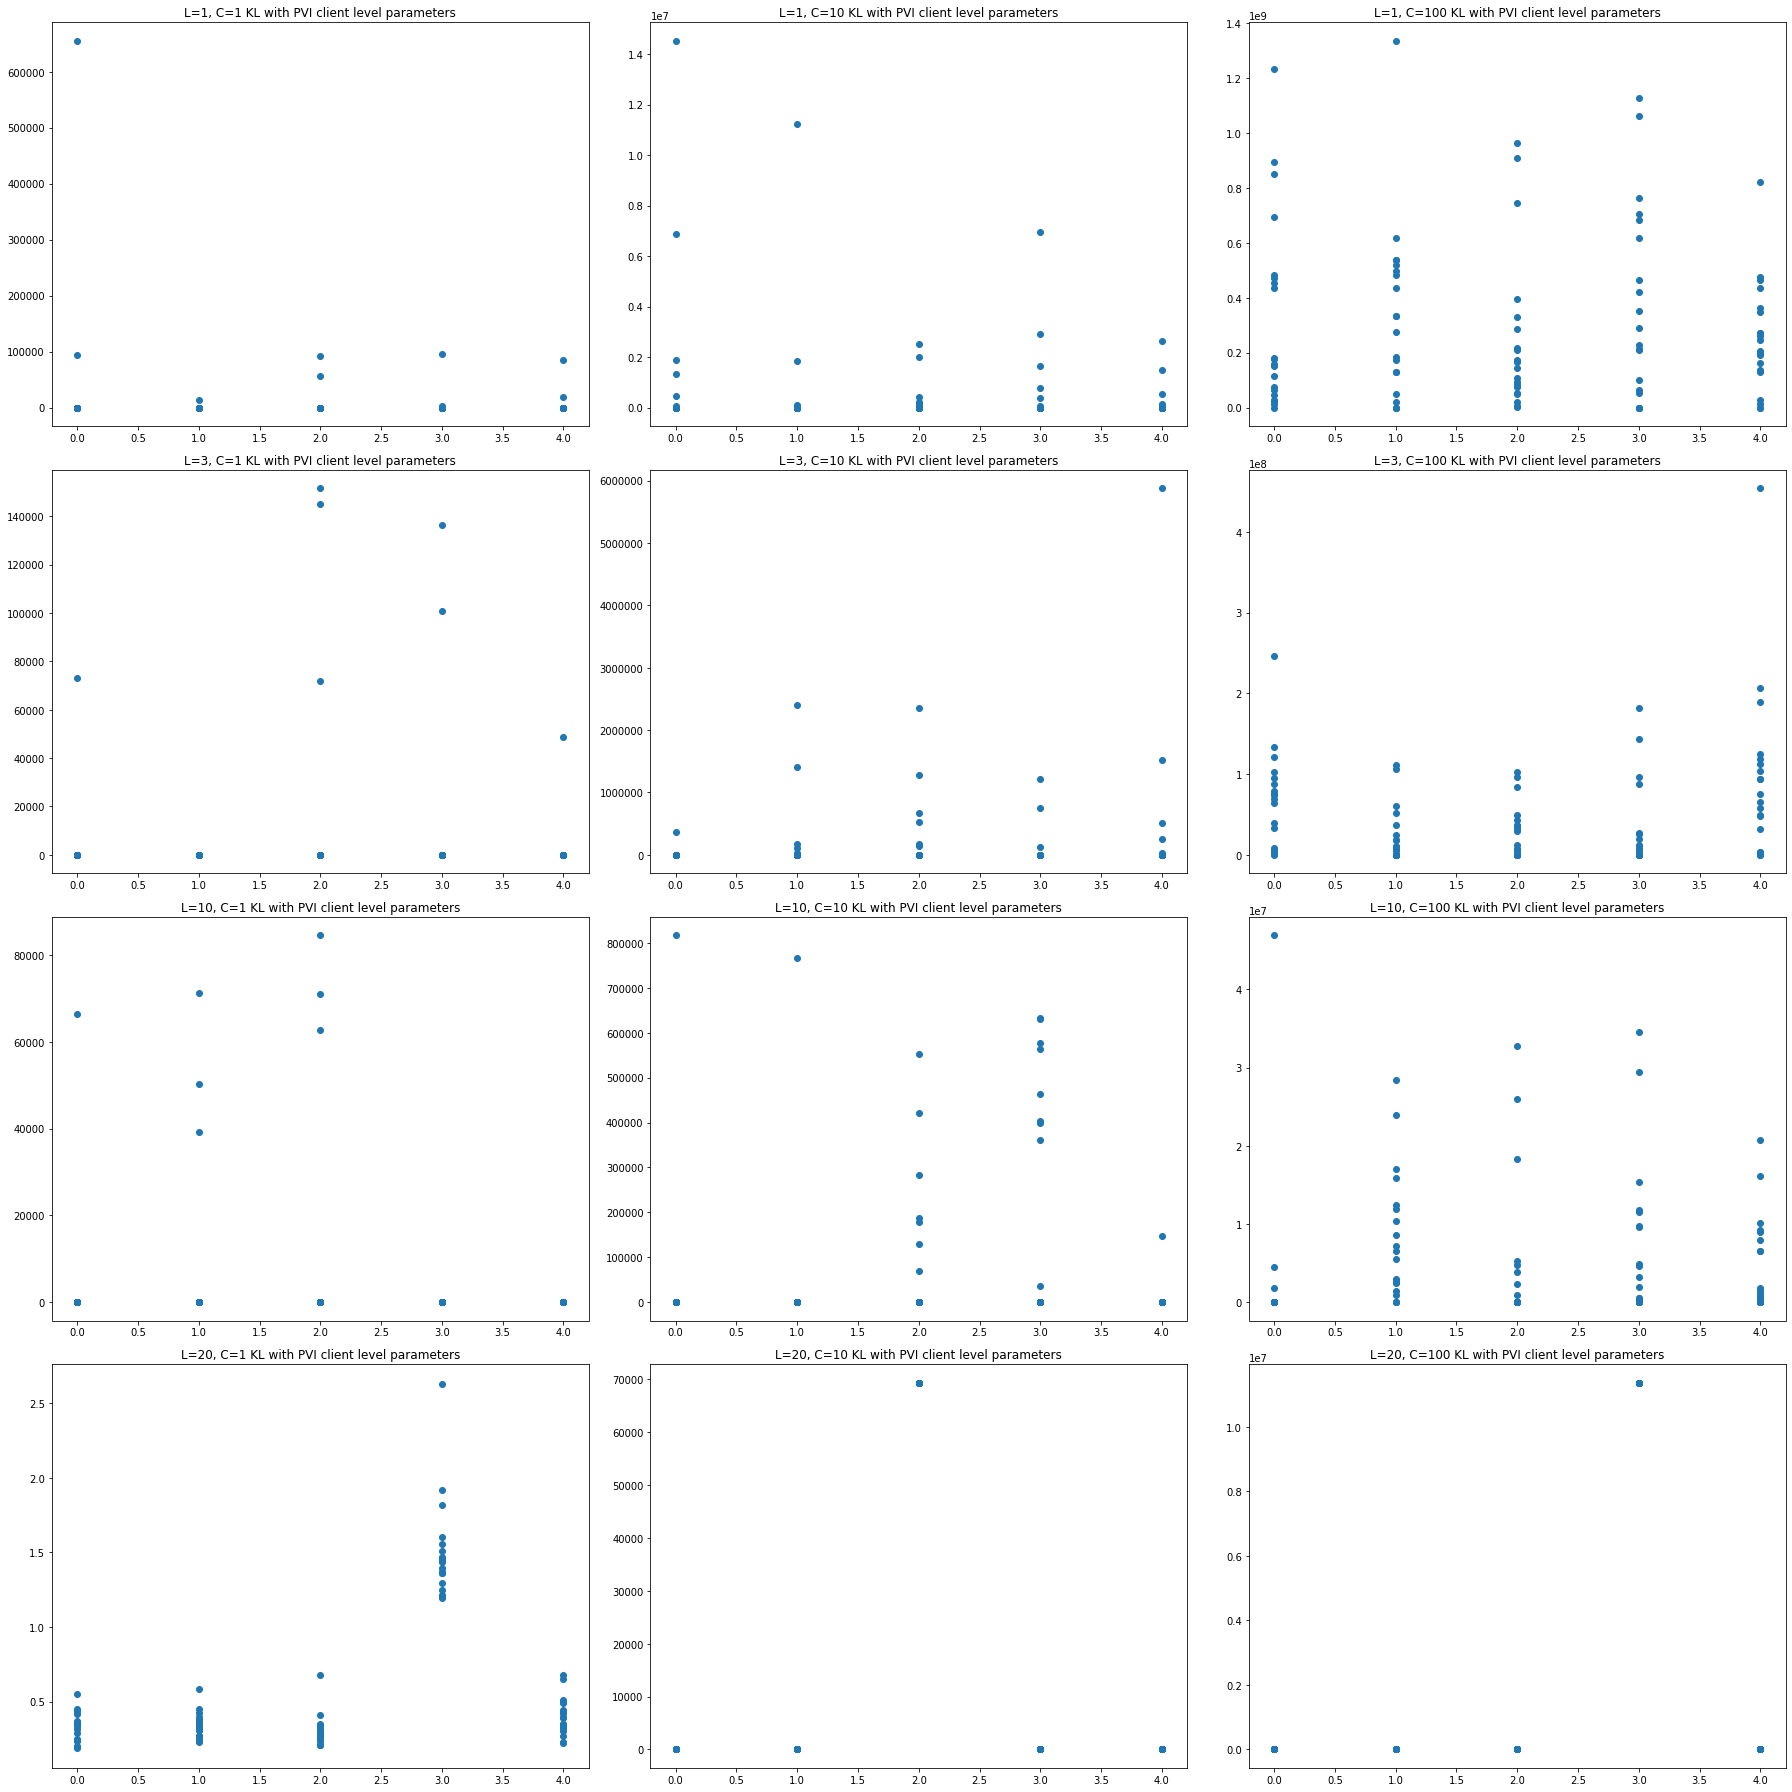

In [7]:
plt.figure(figsize=(25,25))
rows = len(Ls)
cols = len(Cs)

for config, experiments, metrics in zip(adult_grid_configs, adult_grid_experiments, adult_grid_metrics):
    L = config['privacy_settings.L']
    C = config['privacy_settings.C']
    
    L_index = Ls.index(L)
    C_index = Cs.index(C)
    
    plt.subplot(rows, cols, L_index * cols + C_index + 1)
    
    client_parameters = []
    for experiment in experiments:
        file_id = experiment['artifacts'][1]['file_id']
        raw = results_access.get_artifacts_by_id([file_id])[0]
        client_parameters.append(pickle.loads(raw))
    
#     print(client_parameters)
    kls = []
    inds = []
    
    for i, (pvi_params, dp_pvi_params) in enumerate(zip(adult_PVI_client_parameters, client_parameters)):
        for pvi_param, dp_pvi_param in zip(pvi_params, dp_pvi_params):
            mean_1, var_1 = to_mean_var(pvi_param['w_nat_mean'], pvi_param['w_pres'])
            mean_2, var_2 = to_mean_var(dp_pvi_param['w_nat_mean'], dp_pvi_param['w_pres'])
            kl = np.mean(normal_kl(mean_1, var_1, mean_2, var_2))
            kls.append(kl)
            inds.append(i)
            
    plt.scatter(inds, kls)
    plt.title(f'L={L}, C={C} KL with PVI client level parameters')
    
    
plt.tight_layout()

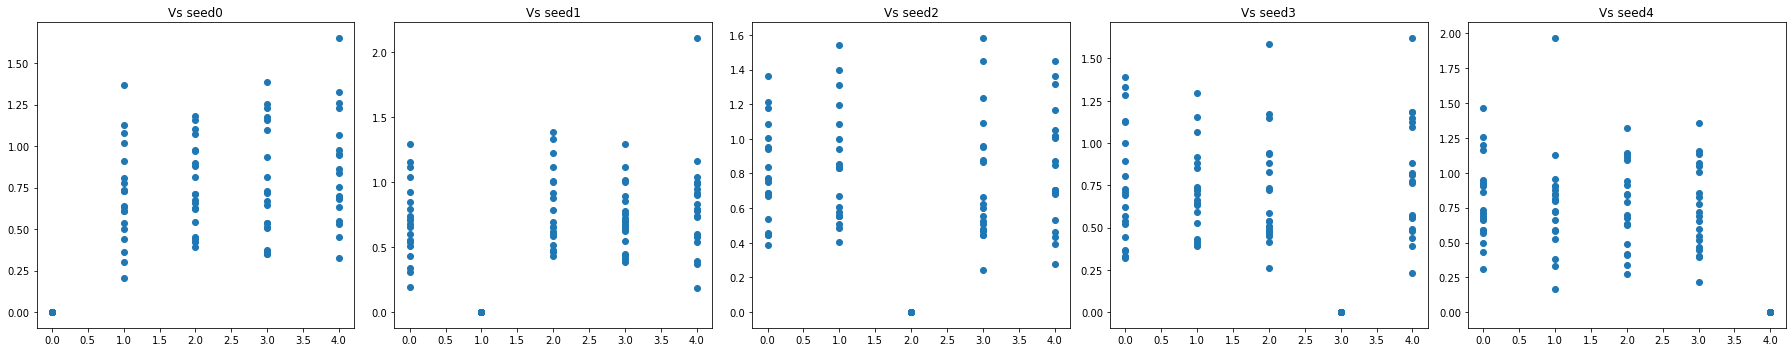

In [8]:
plt.figure(figsize=(25,5))

for i, params_1 in enumerate(adult_PVI_client_parameters):
    plt.subplot(1, len(adult_PVI_client_parameters), i+1)
    kls = []
    inds = []
    for j, params_2 in enumerate(adult_PVI_client_parameters):
        
        for param_1, param_2 in zip(params_1, params_2):
            mean_1, var_1 = to_mean_var(param_1['w_nat_mean'], param_1['w_pres'])
            mean_2, var_2 = to_mean_var(param_2['w_nat_mean'], param_2['w_pres'])
            kl = np.mean(normal_kl(mean_1, var_1, mean_2, var_2))
            kls.append(kl)
            inds.append(j)
    
    plt.scatter(inds, kls)
    plt.title(f'Vs seed{i}')

plt.tight_layout()        

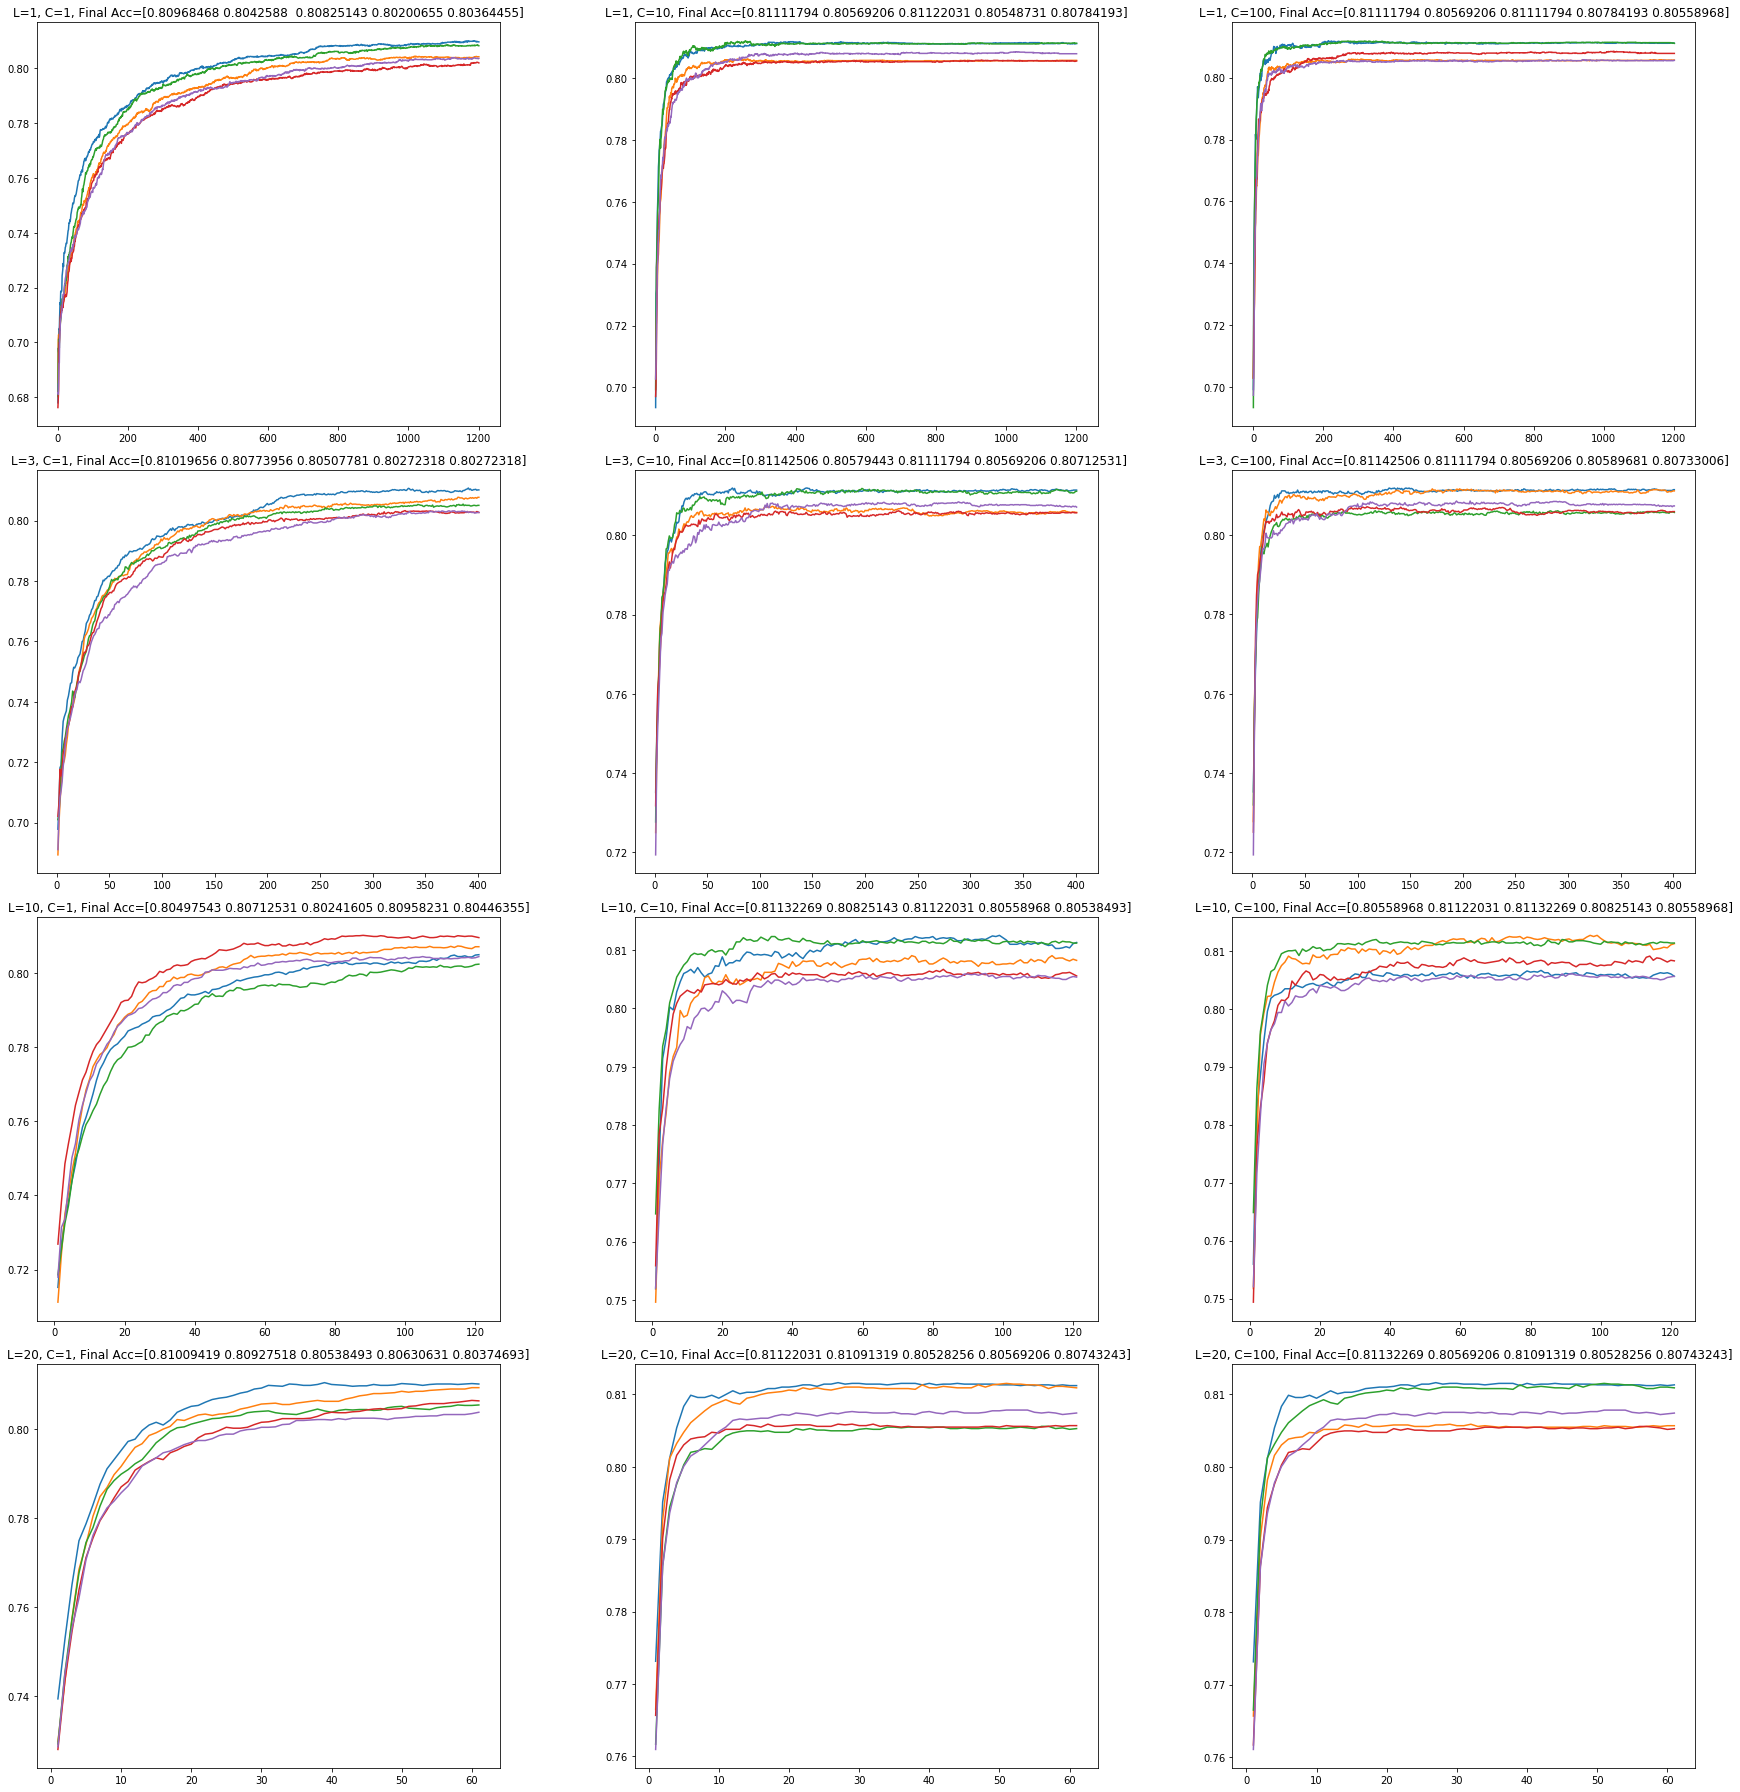

In [10]:
with open('../experiment_configs/M=20_tuning_pres_clipping_fix/client_homo_bad_q_one.yaml', 'r') as f:
    experiment_config = yaml.load(f, Loader=yaml.FullLoader)
    
database_name = experiment_config['database']
if isinstance(database_name, list):
    database_name = database_name[0]
    
experiment_config = flatten_dict(experiment_config)

remove_list = []
for k, v in experiment_config.items():
    if isinstance(v, list):
        if len(v) == 1:
            remove_list.append(k)
        else:
            continue
    else:
        remove_list.append(k)
        
for k in remove_list: experiment_config.pop(k)
    
experiment_config['privacy_settings.sigma_relative'] = 1E-5

all_options = nested_dict_to_option_strings(experiment_config)
product = itertools.product(*all_options)
dp_configs = [dict(item) for item in product]

adult_grid_configs = dp_configs

Ls = experiment_config['privacy_settings.L']
Cs = experiment_config['privacy_settings.C']

results_access = SacredExperimentAccess(database_name=database_name)

adult_grid_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=True, config=config) for config in adult_grid_configs]
# abalone_experiments = [results_access.get_experiments(name='jalko2017_client_exp', complete=True, config=config) for config in abalone_configs]

adult_grid_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in adult_grid_experiments]
# abalone_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "train_accuracy"]) for experiments in abalone_experiments]

plt.figure(figsize=(25,25))
rows = len(Ls)
cols = len(Cs)

for config, experiments, metrics in zip(adult_grid_configs, adult_grid_experiments, adult_grid_metrics):
    L = config['privacy_settings.L']
    C = config['privacy_settings.C']
    
    L_index = Ls.index(L)
    C_index = Cs.index(C)
    
    plt.subplot(rows, cols, L_index * cols + C_index + 1)
        
    if len(metrics) == 0: continue
    values = []
    for metric in metrics:
        values.append(metric[0]['values'])
    values = np.array(values).T
    steps = np.atleast_2d(np.array(metrics[0][0]['steps'])).T
    
    plt.title(f'L={L}, C={C}, Final Acc={values[-1]}')
    
    plt.plot(steps, values)
    
plt.tight_layout()